In [ ]:
!pip install --upgrade tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard
    Found existing installation

mengimport library yang dibutuhkan

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
tf.__version__

'2.15.0'

melakukan mounting google drive untuk menarik dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


mendeklarasikan path dataset, ukuran gambar, dan label

In [ ]:
PATH = '/content/drive/MyDrive/Computer Vision/dataset-coral-baru'
img_height = 224
img_width = 224
labels = ['Acropora Cervicornis', 'Alveopora', 'Caulastraea Furcata', 'Cyphastrea', 'Dendrogyra cylindrus', 'Diploria Strigosa', 'Discosoma', 'Euphyllia', 'Heliofungia actiniformis', 'Palythoa' ,'Ricordea']
print(labels)
print(len(labels))

['Acropora Cervicornis', 'Alveopora', 'Caulastraea Furcata', 'Cyphastrea', 'Dendrogyra cylindrus', 'Diploria Strigosa', 'Discosoma', 'Euphyllia', 'Heliofungia actiniformis', 'Palythoa', 'Ricordea']
11


mendeklarasikan jenis terumbu karang yang ilegal

In [ ]:
ilegal_coral = ['Acropora Cervicornis','Dendrogyra cylindrus','Diploria Strigosa','Euphyllia']

Meload Dataset dan mengaugmentasi menggunakan ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = .2,
    height_shift_range = .2,
    shear_range = .2,
    zoom_range = .2,
    horizontal_flip=True,
    fill_mode = 'nearest',
    validation_split = .2
)
train_generator = train_datagen.flow_from_directory(
    PATH,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)
val_generator = train_datagen.flow_from_directory(
    PATH,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 980 images belonging to 11 classes.
Found 238 images belonging to 11 classes.


Membuat function untuk memanggil EfficientNetB6

In [ ]:
def feature_extractor_Resnet(inputs):

  feature_extractor = tf.keras.applications.ResNet101V2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)

  x = tf.keras.layers.GlobalAveragePooling2D()(feature_extractor)
  return x

Membuat function untuk membuat classifier model

In [ ]:
def classifier(input):
    x = tf.keras.layers.BatchNormalization()(input)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.7)(x)
    x = tf.keras.layers.Dense(11, activation="softmax", name="classification")(x)
    return x

Membuat Function untuk membuat model secara keseluruhan

In [ ]:
def final_model(inputs):

    Resnet101_feature_extractor = feature_extractor_Resnet(inputs)
    classification_output = classifier(Resnet101_feature_extractor)

    return classification_output

Membuat function untuk mendefinisikan dan compile model

In [ ]:
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(224,224,3))

  classification_output = final_model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  return model

memanggil dan menampilkan struktur model

In [ ]:
model = define_compile_model()

model.summary()

171317808/171317808 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                            

mendeklarasikan callback yang dibutuhkan untuk melatih model

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    verbose = 1
)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.9,
    min_lr=1e-6,
    patience=2,
    verbose=1
)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/Computer Vision/coral_classification_checkpoint_Resnet101V2.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

Melatih model

In [ ]:
EPOCHS = 100
history = model.fit(train_generator, epochs=EPOCHS, steps_per_epoch=train_generator.samples//64,validation_data = val_generator, validation_steps=val_generator.samples//64,callbacks=[early_stopping,lr_scheduler,checkpoint])

Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 3.3740 - accuracy: 0.1638 
Epoch 1: val_loss improved from inf to 3.91176, saving model to /content/drive/MyDrive/Computer Vision/coral_classification_checkpoint_Resnet101V2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 [==============================] - 473s 30s/step - loss: 3.3740 - accuracy: 0.1638 - val_loss: 3.9118 - val_accuracy: 0.0208 - lr: 1.0000e-04
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 2.2946 - accuracy: 0.3548
Epoch 2: val_loss improved from 3.91176 to 2.88023, saving model to /content/drive/MyDrive/Computer Vision/coral_classification_checkpoint_Resnet101V2.h5
15/15 [==============================] - 104s 7s/step - loss: 2.2946 - accuracy: 0.3548 - val_loss: 2.8802 - val_accuracy: 0.1458 - lr: 1.0000e-04
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 1.5422 - accuracy: 0.5644
Epoch 3: val_loss improved from 2.88023 to 1.68874, saving model to /content/drive/MyDrive/Computer Vision/coral_classification_checkpoint_Resnet101V2.h5
15/15 [==============================] - 104s 7s/step - loss: 1.5422 - accuracy: 0.5644 - val_loss: 1.6887 - val_accuracy: 0.4479 - lr: 1.0000e-04
Epoch 4/100
15/15 [==============================] - ETA: 0s

meload model yang sudah terlatih dari checkpoint yang disimpan di google drive

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Computer Vision/coral_classification_checkpoint_Resnet101V2.h5')

melakukan testing pada model yang sudah terlatih

In [ ]:
y_pred = model.predict(val_generator)
y_pred = np.argmax(y_pred, axis=1)
y_test = val_generator.classes

4/4 [==============================] - 9s 2s/step


menampilkan classification report yang berisikan precision, recall dan f1-score dari setiap kelas

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=labels))

0.8991596638655462
                          precision    recall  f1-score   support

    Acropora Cervicornis       0.96      0.96      0.96        24
               Alveopora       0.80      1.00      0.89        20
     Caulastraea Furcata       1.00      0.92      0.96        25
              Cyphastrea       0.94      0.84      0.89        19
    Dendrogyra cylindrus       0.89      1.00      0.94        17
       Diploria Strigosa       1.00      1.00      1.00        30
               Discosoma       0.83      0.79      0.81        24
               Euphyllia       0.76      0.83      0.79        23
Heliofungia actiniformis       0.89      0.76      0.82        21
                Palythoa       1.00      1.00      1.00        10
                Ricordea       0.88      0.84      0.86        25

                accuracy                           0.90       238
               macro avg       0.90      0.90      0.90       238
            weighted avg       0.90      0.90      0.90

menampilkan confusion matrix

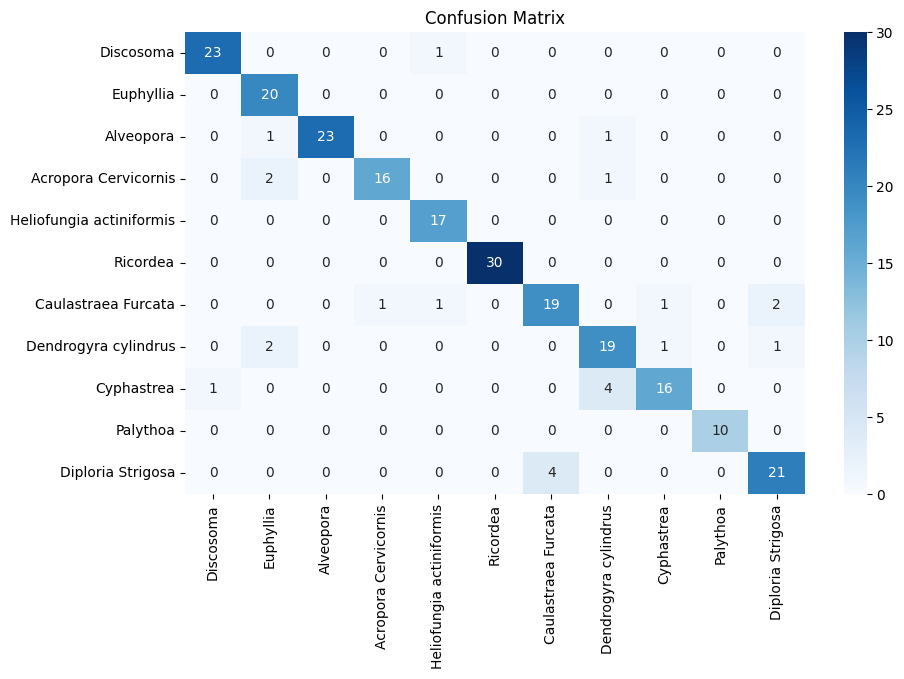

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.show()